In [50]:
!pip install datasets
!pip install tokenizers==0.10.0rc1
!pip install wandb

  Using cached tokenizers-0.10.0rc1.tar.gz (208 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build tokenizers


  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [51 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-310
      creating build\lib.win-amd64-cpython-310\tokenizers
      copying py_src\tokenizers\__init__.py -> build\lib.win-amd64-cpython-310\tokenizers
      creating build\lib.win-amd64-cpython-310\tokenizers\models
      copying py_src\tokenizers\models\__init__.py -> build\lib.win-amd64-cpython-310\tokenizers\models
      creating build\lib.win-amd64-cpython-310\tokenizers\decoders
      copying py_src\tokenizers\decoders\__init__.py -> build\lib.win-amd64-cpython-310\tokenizers\decoders
      creating build\lib.win-amd64-cpython-310\tokenizers\normalizers
      copying py_src\tokenizers\normalizers\__init__.py -> build\lib.win-amd64-cpython-310\tokenizers\normalizers
      creating build\lib.

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import datasets
import tokenizers
import wandb
from tqdm.auto import tqdm
from nltk.util import ngrams

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt

## О формате заданий

### Coding tasks


Место для вашего кода отмечено блоками `# YOUR CODE STARTS` ... `#YOUR CODE ENDS` и ваше решение должно быть строго между ними. 

Чтобы решить задачу, вам придётся смотреть в документацию соответствующего фреймворка. Этот навык очень важен, и в начале мы будем намекать вам на название метода, который вам нужно использовать. Такой подход позволит плавно приблизить вас к более реалистичным задачам.



![image.png](https://files.realpython.com/media/Practical-Text-Classification-with-Keras-and-Python_Watermark.fe326bd75146.jpg)

Image source: [тык](https://realpython.com/python-keras-text-classification/)

In [52]:
text_dataset = datasets.load_dataset("imdb")

Found cached dataset imdb (C:/Users/Пользователь/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 16.83it/s]


**IMDB** - это датасет по классификации эмоциональной окраски. Вам нужно предсказать положительный ли отзыв к фильму по его тексту. Это довольно простая задача и она хорошо решается даже линейными моделями. Для доступа к нему мы используем библиотеку `datasets` - она содержит в себе много интересных текстовых датасетов.

Тренировочная и тстовая части IMDB достаточно большие - каждая состоит из 25 тысяч примеров.

In [53]:
text_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Как мы видим, классы сбалансированны, что позволяет использовать accuracy как простую и интерпретируемую метрику, хорошо показывающую качество модели.

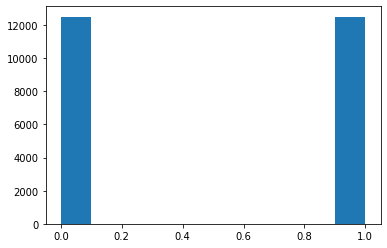

In [54]:
train_labels = [e['label'] for e in text_dataset['train']]
plt.hist(train_labels)
plt.show()

In [55]:
text_dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [56]:
text_dataset['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

# Classification using a linear model

Линейная модель - очень сильный бейзлайн и в некоторых задачах классификации вам даже не надо идти дальше линейной модели - она уже достаточно хороша. А также её можно написать менее чем в 10 строчекю Поэтому всегда стоит начинать решение любой задачи с ленейного бейзлайна.

Давайте вспомним библиотеку `sklearn` и напишем линейную модельку. Для векторизации текста мы будем использовать `TfidfVectorizer`, а в качестве модели `LogisticRegression`.


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [58]:
# TASK 1.1: create TfidfVectorizer object and fit it on out training set texts
# Our implementation is 2 lines
# YOUR CODE STARTS
vectorizer = TfidfVectorizer()
vectorizer.fit(text_dataset['train']['text'])

# YOUR CODE ENDS

TfidfVectorizer()

In [59]:
# TASK 1.2:
# 1. convert your texts to tf-idf vectors using .transform (training texts and test texts too)
# 2. convert your labels into numpy arrays (both training and test labels)
# Or implementatin is 4 lines

# YOUR CODE STARTS
X_train = vectorizer.transform(text_dataset['train']['text'])
y_train = np.array(text_dataset['train']['label'])

X_test = vectorizer.transform(text_dataset['test']['text'])
y_test = np.array(text_dataset['test']['label'])
# YOUR CODE ENDS

In [60]:
X_train, y_train

(<25000x74849 sparse matrix of type '<class 'numpy.float64'>'
 	with 3445861 stored elements in Compressed Sparse Row format>,
 array([0, 0, 0, ..., 1, 1, 1]))

In [61]:
# TASK 1.3: create LogisticRegression model object and fit the model
# Our implementation is 2 lines
# YOUR CODE STARTS
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)


# YOUR CODE ENDS

LogisticRegression(random_state=42)

А теперь мы используем нашу модель для того, чтобы предсказать классы на тестовом сете и считаем accuracy.

In [62]:
predictions = model.predict(X_test)

print(type(predictions))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [63]:
# note that we can use vector operations, because we deal with numpy tensors
accuracy = (predictions == y_test).mean()
accuracy

0.88316

**OMG so accurate, much machine learning**

Давайте предскажем позитивны ли такие комментарии:

In [64]:
positive_comment = 'This movie is awesome!'

vec = vectorizer.transform([positive_comment])
model.predict(vec)

array([1])

In [65]:
negative_comment = 'This movie is awful!'

vec = vectorizer.transform([negative_comment])
model.predict(vec)

array([0])

Как мы увидели, даже такая простая модель может хорошо классифицировать текст (accuracy 0.9 - это довольно много, тк выборка сбалансированна).

Кстати, использование модели LinearSVM обычно работает даже лучше, чем логистическая регрессия. Рекомендуем попробовать и сравнить.

Что такое SVM: [тык](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)

Ещё один простой метод улучшить линейную модель - использовать n-gram в вашем TF-IDF. Не забудьте указать параметр `max_features` (хорошое число 50 000), а то при большом количестве фичей модель может начать переобучаться.

In [66]:
# YOUR CODE STARTS
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train, y_train)

svm_predictions = svm_model.predict(X_test)
accuracy = (svm_predictions == y_test).mean()
accuracy
# YOUR CODE ENDS

0.8772

In [67]:
# YOUR CODE STARTS
vectorizer_n = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
vectorizer_n.fit(text_dataset['train']['text'])

X_train = vectorizer_n.transform(text_dataset['train']['text'])
y_train = np.array(text_dataset['train']['label'])

X_test = vectorizer_n.transform(text_dataset['test']['text'])
y_test = np.array(text_dataset['test']['label'])


model_n = LogisticRegression(random_state=42)
model_n.fit(X_train, y_train)

n_predictions = model_n.predict(X_test)
accuracy = (n_predictions == y_test).mean()
accuracy

# YOUR CODE ENDS

0.89436